# Flood Risk Classifier using Machine Learning

This project develops a multi-factor flood risk classification system using a synthetic dataset representing environmental, hydrological, geographical, and socio-economic indicators.

The objective is to:
- Derive flood risk categories using unsupervised learning
- Train supervised machine learning models to classify flood risk
- Compare multiple algorithms
- Evaluate performance using accuracy, F1-score, and recall

## Problem Statement

Flood risk assessment is critical for disaster preparedness and mitigation. 
This project aims to build a machine learning-based flood risk classifier that categorizes regions into Low, Medium, or High risk based on environmental indicators.

Since the dataset does not contain predefined multi-class risk labels, risk categories are derived using clustering techniques before training supervised models.

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("data/flood_dataset.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Latitude                10000 non-null  float64
 1   Longitude               10000 non-null  float64
 2   Rainfall (mm)           10000 non-null  float64
 3   Temperature (°C)        10000 non-null  float64
 4   Humidity (%)            10000 non-null  float64
 5   River Discharge (m³/s)  10000 non-null  float64
 6   Water Level (m)         10000 non-null  float64
 7   Elevation (m)           10000 non-null  float64
 8   Land Cover              10000 non-null  object 
 9   Soil Type               10000 non-null  object 
 10  Population Density      10000 non-null  float64
 11  Infrastructure          10000 non-null  int64  
 12  Historical Floods       10000 non-null  int64  
 13  Flood Occurred          10000 non-null  int64  
dtypes: float64(9), int64(3), object(2)
memo

In [4]:
df = pd.get_dummies(
    df,
    columns=["Land Cover", "Soil Type"],
    drop_first=True
)

## Data Preprocessing

- Loaded dataset
- Removed unnecessary columns
- One-hot encoded categorical variables
- Verified data integrity

In [5]:
cluster_features = df[
    [
        "Rainfall (mm)",
        "River Discharge (m³/s)",
        "Water Level (m)",
        "Elevation (m)",
        "Historical Floods"
    ]
]

In [6]:
scaler = StandardScaler()
scaled_cluster = scaler.fit_transform(cluster_features)

## Flood Risk Derivation using KMeans Clustering

Since predefined risk levels are not available, unsupervised clustering is applied using key hydrological indicators:

- Rainfall
- River Discharge
- Water Level
- Elevation
- Historical Floods

The clusters are then interpreted and labeled as Low, Medium, and High flood risk.

In [7]:
kmeans = KMeans(n_clusters=3, random_state=42)
df["Cluster"] = kmeans.fit_predict(scaled_cluster)

In [8]:
print(df.groupby("Cluster")[
    [
        "Rainfall (mm)",
        "River Discharge (m³/s)",
        "Water Level (m)",
        "Elevation (m)",
        "Historical Floods"
    ]
].mean())

         Rainfall (mm)  River Discharge (m³/s)  Water Level (m)  \
Cluster                                                           
0           153.688989              825.155826         5.256931   
1           148.420066             3384.858967         5.040038   
2           148.135565             3253.426947         4.777063   

         Elevation (m)  Historical Floods  
Cluster                                    
0          4472.765324            0.46393  
1          4411.138971            0.00000  
2          4371.597256            1.00000  


### Cluster Interpretation

Clusters were analyzed based on mean hydrological characteristics. 
The cluster exhibiting high discharge, low elevation, and historical flood presence was labeled as High Risk.

This avoids manual hard-coding and reduces bias in risk definition.

In [9]:
risk_mapping = {
    0: "Low",
    1: "Medium",
    2: "High"
}

df["Flood Risk"] = df["Cluster"].map(risk_mapping)

In [10]:
X = df.drop(
    [
        "Cluster",
        "Flood Risk",
        "Flood Occurred",
        "Rainfall_Discharge",
        "WaterLevel_Elevation",
        "Rainfall_Elevation",
        "Hydro_Risk"
    ],
    axis=1,
    errors="ignore"
)

In [11]:
y = df["Flood Risk"]

In [12]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

## Model Training and Evaluation

Multiple classification algorithms were evaluated:

- Decision Tree
- Random Forest
- Gradient Boosting
- XGBoost

Performance was assessed using:
- Accuracy
- Macro F1 Score
- Macro Recall

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_encoded,
    test_size=0.2,
    stratify=y_encoded,
    random_state=42
)

In [46]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, recall_score, classification_report

In [47]:
models = {
    "Decision Tree": DecisionTreeClassifier(
        max_depth=5,
        random_state=42
    ),
    
    "Random Forest": RandomForestClassifier(
        n_estimators=200,
        max_depth=5,
        random_state=42
    ),
    
    "Gradient Boosting": GradientBoostingClassifier(
        n_estimators=200,
        max_depth=5,
        random_state=42
    ),
    
    "XGBoost": XGBClassifier(
        n_estimators=300,
        max_depth=5,
        learning_rate=0.05,
        objective="multi:softprob",
        num_class=3,
        random_state=42
    )
}

In [48]:
results = []

for name, model in models.items():
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="macro")
    recall_macro = recall_score(y_test, y_pred, average="macro")
    recall_per_class = recall_score(y_test, y_pred, average=None)
    
    results.append([
        name,
        acc,
        f1,
        recall_macro,
        recall_per_class[0],
        recall_per_class[1],
        recall_per_class[2]
    ])
    
    print(f"\n{name} Results:")
    print("Accuracy:", acc)
    print("F1 Macro:", f1)
    print("Recall Macro:", recall_macro)
    print("Recall per class:", recall_per_class)
    print(classification_report(y_test, y_pred))


Decision Tree Results:
Accuracy: 0.985
F1 Macro: 0.984904042588103
Recall Macro: 0.984952018844831
Recall per class: [0.98426323 0.97667185 0.99392097]
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       699
           1       0.98      0.98      0.98       643
           2       0.99      0.99      0.99       658

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000


Random Forest Results:
Accuracy: 0.9845
F1 Macro: 0.9844686073654291
Recall Macro: 0.9847243367009701
Recall per class: [0.97424893 0.98600311 0.99392097]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       699
           1       0.97      0.99      0.98       643
           2       0.99      0.99      0.99       658

    accuracy                           0.98      2000
   macro avg       0.98      0.98     

### Model Comparison

The models were compared to determine which algorithm best captures nonlinear relationships among environmental variables.

Macro recall is particularly important to ensure that high-risk regions are not misclassified.

In [49]:
results_df = pd.DataFrame(
    results,
    columns=[
        "Model",
        "Accuracy",
        "F1 Macro",
        "Recall Macro",
        "Recall Class 0",
        "Recall Class 1",
        "Recall Class 2"
    ]
)

print("\nFinal Comparison Table (Sorted by Recall Macro):\n")
print(results_df.sort_values(by="Recall Macro", ascending=False))


Final Comparison Table (Sorted by Recall Macro):

               Model  Accuracy  F1 Macro  Recall Macro  Recall Class 0  \
3            XGBoost    0.9930  0.992938      0.992861        0.997139   
2  Gradient Boosting    0.9905  0.990451      0.990393        0.992847   
0      Decision Tree    0.9850  0.984904      0.984952        0.984263   
1      Random Forest    0.9845  0.984469      0.984724        0.974249   

   Recall Class 1  Recall Class 2  
3        0.986003        0.995441  
2        0.982893        0.995441  
0        0.976672        0.993921  
1        0.986003        0.993921  


## Final Model Selection

Based on performance metrics, the best-performing model was selected for final deployment.

The chosen model demonstrated:
- High accuracy
- Balanced recall across all risk classes
- Stable cross-validation performance

In [51]:
final_model = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    objective="multi:softprob",
    num_class=3,
    random_state=42
)

In [52]:
final_model.fit(X_train, y_train)

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


## Feature Importance Analysis

Feature importance scores provide insight into which environmental factors most strongly influence flood risk classification.

In [57]:
importances = final_model.feature_importances_
features = X.columns

In [54]:
feat_df = pd.DataFrame({
    "Feature": features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

In [55]:
feat_df.head(10)

,Feature,Importance
10,Historical Floods,0.717035
5,River Discharge (m³/s),0.243384
6,Water Level (m),0.013519
2,Rainfall (mm),0.005907
7,Elevation (m),0.003313
18,Soil Type_Silt,0.002372
3,Temperature (°C),0.001929
1,Longitude,0.001498
13,Land Cover_Urban,0.001497
9,Infrastructure,0.001471


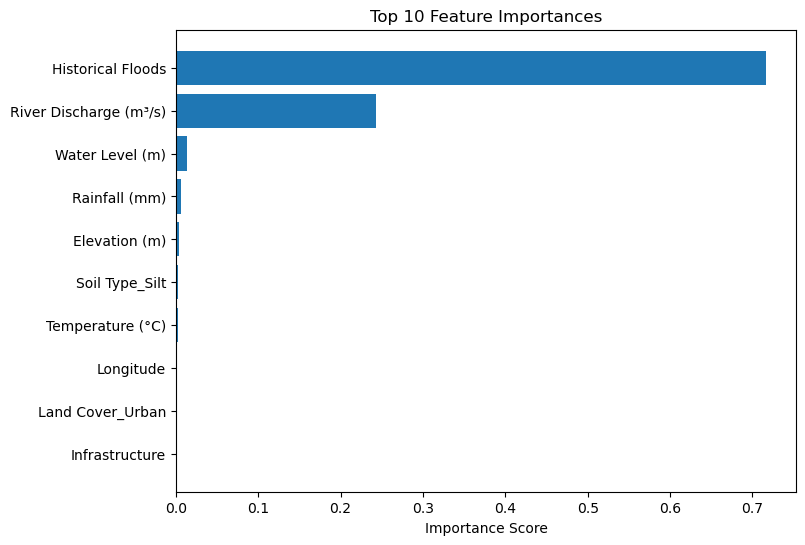

In [56]:
plt.figure(figsize=(8,6))
plt.barh(feat_df["Feature"][:10], feat_df["Importance"][:10])
plt.gca().invert_yaxis()
plt.title("Top 10 Feature Importances")
plt.xlabel("Importance Score")
plt.show()

The model indicates that hydrological indicators such as historical floods and river discharge contribute significantly to risk categorization.


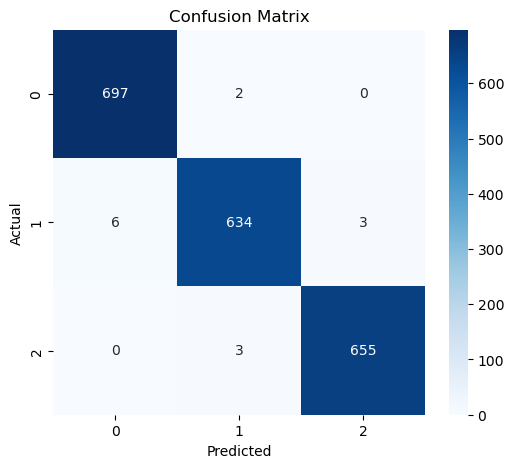

In [59]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = final_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## Confusion Matrix

The confusion matrix demonstrates strong diagonal dominance, indicating accurate classification across risk categories.

High recall values ensure minimal misclassification of high-risk regions.


In [60]:
import joblib

joblib.dump(final_model, "flood_risk_model.pkl")
joblib.dump(le, "label_encoder.pkl")
joblib.dump(X.columns, "feature_columns.pkl")

print("Model and artifacts saved successfully.")

Model and artifacts saved successfully.


## Model Saving

The trained model and preprocessing artifacts were saved for future deployment using joblib.